In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import math, time

In [5]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
print("Train Head\n", train.head())
print("Test Head\n", test.head())

print("Train Shape\n", train.shape)
print("Test Shape\n", test.shape)

Train Head
   Customer ID               Name Gender  Age  Income (USD) Income Stability  \
0     C-36995   Frederica Shealy      F   56       1933.05              Low   
1     C-33999  America Calderone      M   32       4952.91              Low   
2      C-3770      Rosetta Verne      F   65        988.19             High   
3     C-26480         Zoe Chitty      F   65           NaN             High   
4     C-23459       Afton Venema      F   31       2614.77              Low   

  Profession     Type of Employment    Location  Loan Amount Request (USD)  \
0    Working            Sales staff  Semi-Urban                   72809.58   
1    Working                    NaN  Semi-Urban                   46837.47   
2  Pensioner                    NaN  Semi-Urban                   45593.04   
3  Pensioner                    NaN       Rural                   80057.92   
4    Working  High skill tech staff  Semi-Urban                  113858.89   

   ...  Credit Score No. of Defaults Has Act

In [6]:
print("Train Null Values\n", train.isnull().sum())
print("Describe\n", train.describe())

print("Test Null Values\n", test.isnull().sum())

Train Null Values
 Customer ID                       0
Name                              0
Gender                           53
Age                               0
Income (USD)                   4576
Income Stability               1683
Profession                        0
Type of Employment             7270
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     172
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2493
Credit Score                   1703
No. of Defaults                   0
Has Active Credit Card         1566
Property ID                       0
Property Age                   4850
Property Type                     0
Property Location               356
Co-Applicant                      0
Property Price                    0
Loan Sanction Amount (USD)      340
dtype: int64
Describe
                 Age  Income (USD)  Loan Amount Request (USD)  \
count  30000.000000  2.542400e

In [35]:
target_col = "Loan Sanction Amount (USD)"

# Drop rows with NaN target
train = train.dropna(subset=[target_col])

In [37]:
train.shape

(29660, 24)

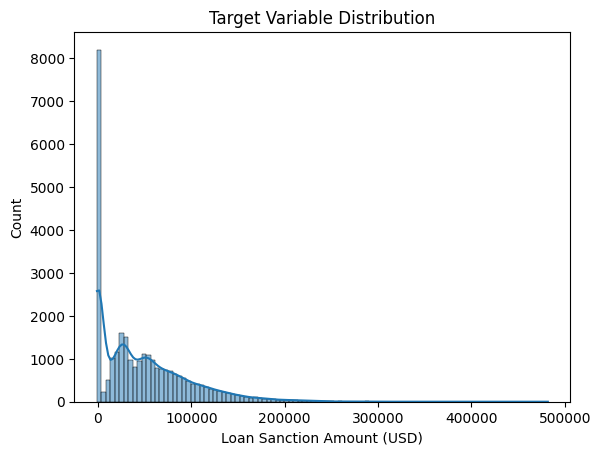

In [110]:
sns.histplot(train["Loan Sanction Amount (USD)"], kde=True)
plt.title("Target Variable Distribution")
plt.savefig("images/targetDist.png", dpi=150)
plt.show()

In [39]:
numerical_cols = train.select_dtypes(include=["int64", "float64"]).columns.drop(target_col)
numerical_cols

Index(['Age', 'Income (USD)', 'Loan Amount Request (USD)',
       'Current Loan Expenses (USD)', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Property ID', 'Property Age', 'Property Type',
       'Co-Applicant', 'Property Price'],
      dtype='object')

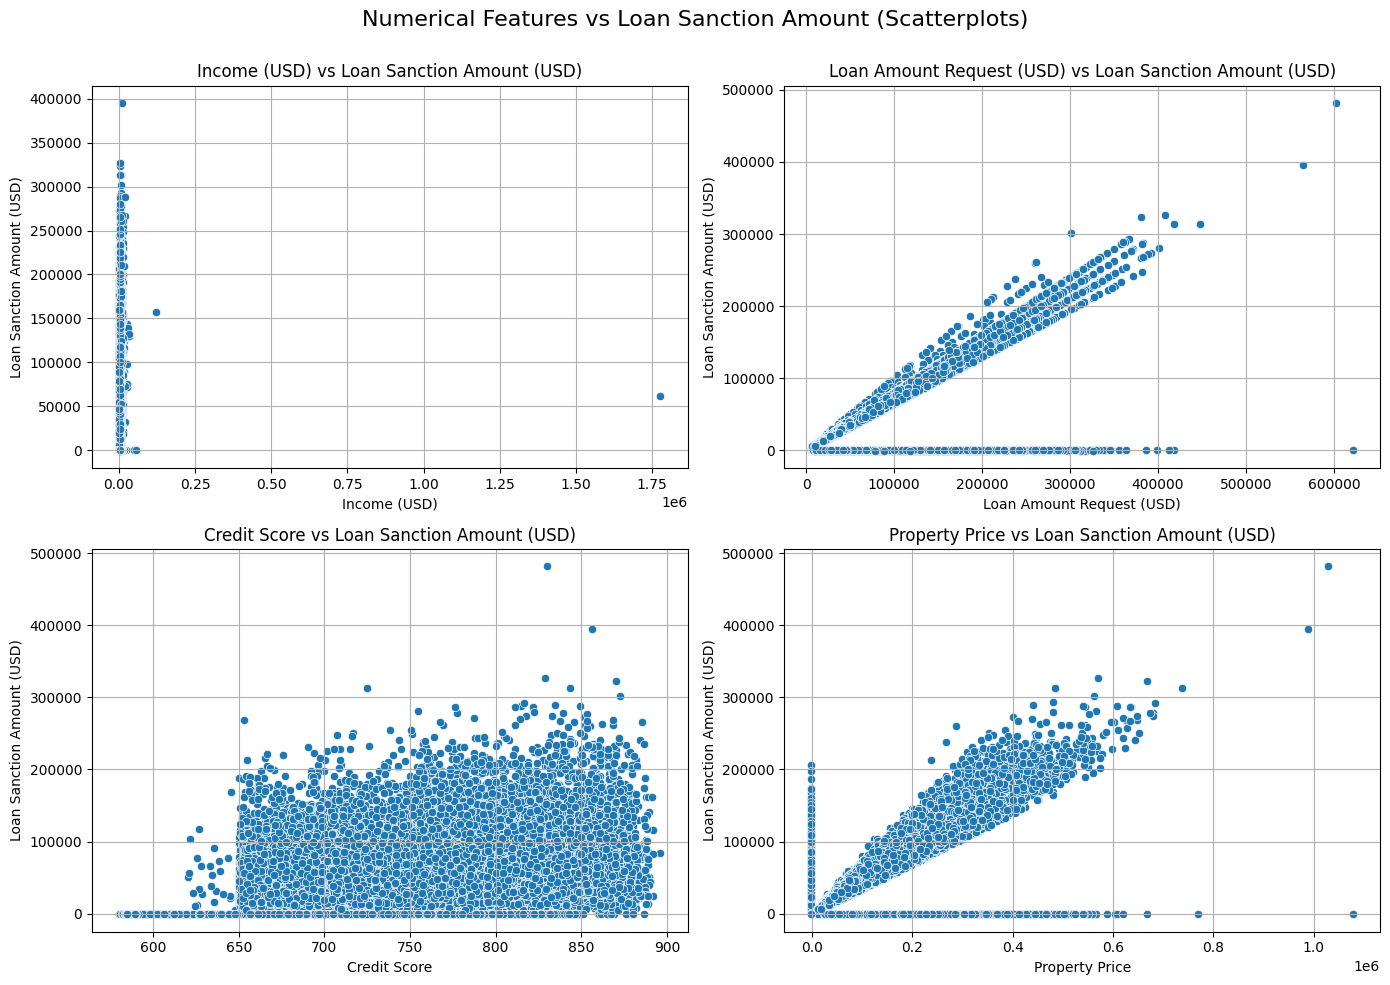

In [111]:
target_col = "Loan Sanction Amount (USD)"

# Select 4 numerical features
numerical_cols = [
    "Income (USD)",
    "Loan Amount Request (USD)",
    "Credit Score",
    "Property Price"
]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

fig.suptitle(
    "Numerical Features vs Loan Sanction Amount (Scatterplots)\n",
    fontsize=16
)

for i, col in enumerate(numerical_cols):
    sns.scatterplot(
        data=train,
        x=col,
        y=target_col,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} vs {target_col}")
    axes[i].grid(True)

plt.tight_layout()
plt.savefig("images/scatterPlots.png", dpi=150)
plt.show()

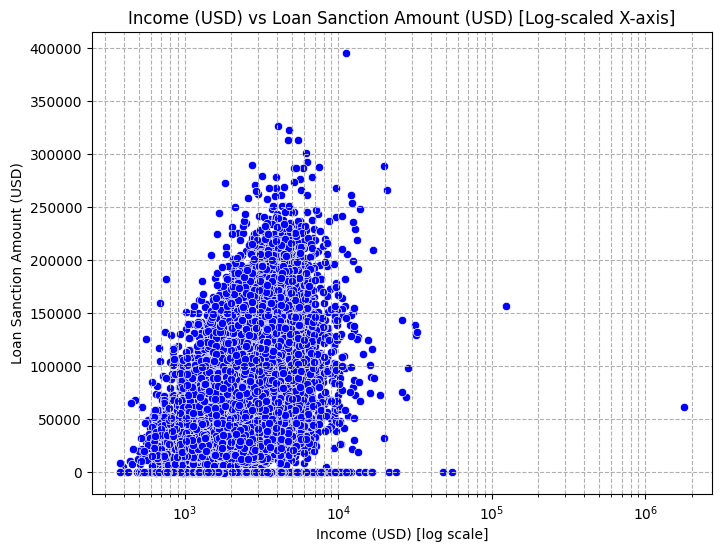

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train["Income (USD)"], y=train["Loan Sanction Amount (USD)"], color='b')
plt.xscale('log')  # log scale on x-axis
plt.xlabel("Income (USD) [log scale]")
plt.ylabel("Loan Sanction Amount (USD)")
plt.title("Income (USD) vs Loan Sanction Amount (USD) [Log-scaled X-axis]")
plt.grid(True, which="both", ls="--")
plt.show()

In [42]:
categorical_cols = train.select_dtypes(include=["object", "category"]).columns
categorical_cols

Index(['Customer ID', 'Name', 'Gender', 'Income Stability', 'Profession',
       'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2',
       'Has Active Credit Card', 'Property Location'],
      dtype='object')

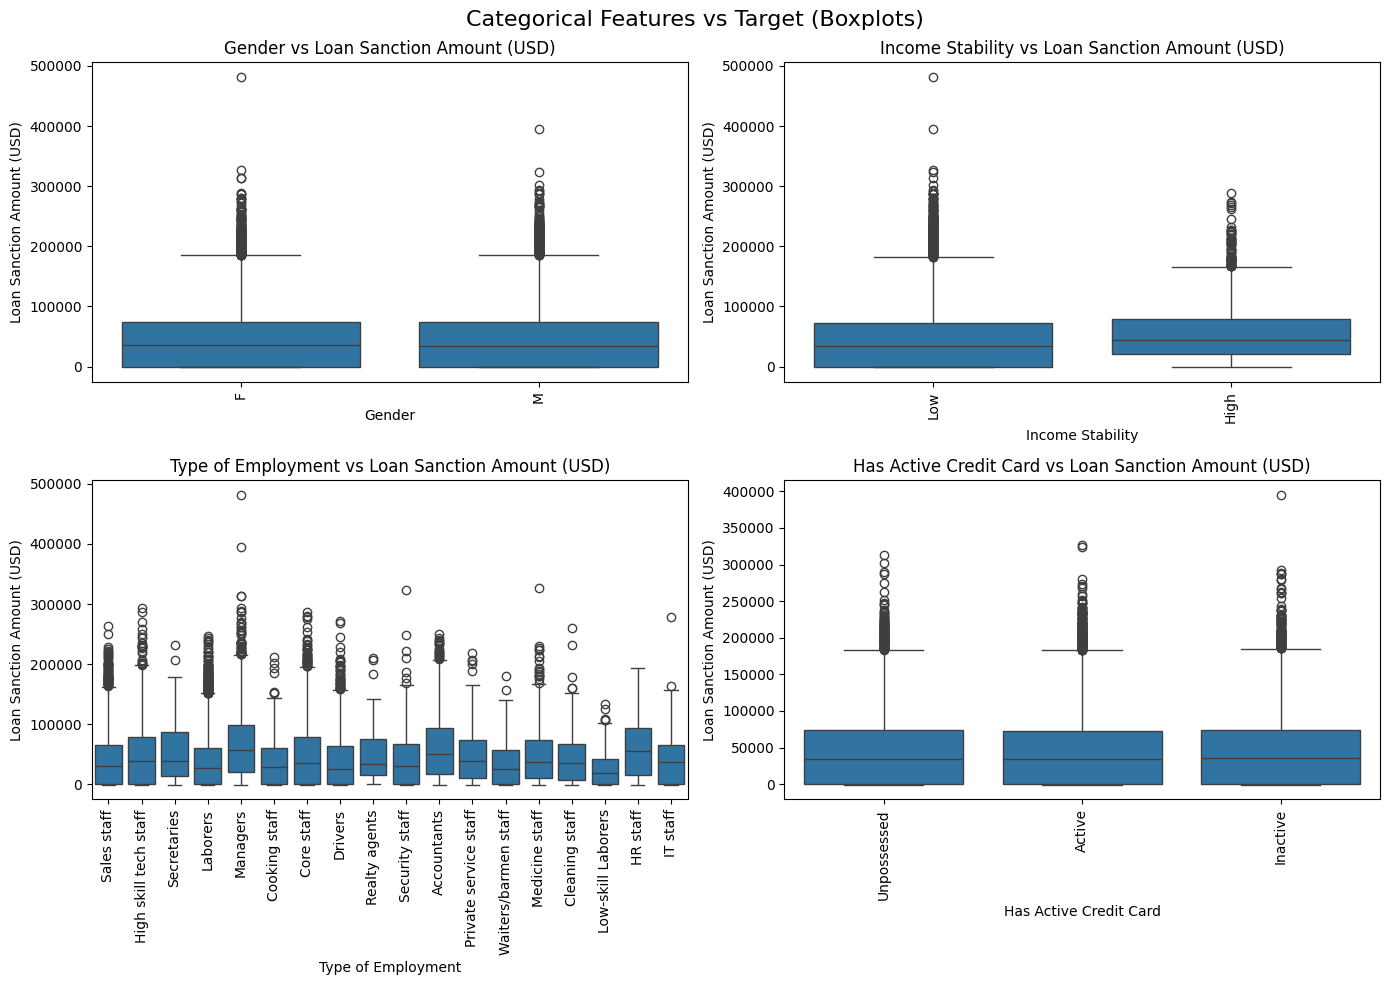

In [112]:
# Target column
target_col = "Loan Sanction Amount (USD)"   # ⚠️ change if needed

# Select 4 categorical columns
categorical_cols = [
    "Gender",
    "Income Stability",
    "Type of Employment",
    "Has Active Credit Card"
]

# Create subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

fig.suptitle("Categorical Features vs Target (Boxplots)", fontsize=16)

for i, col in enumerate(categorical_cols):
    sns.boxplot(
        data=train,
        x=col,
        y=target_col,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} vs {target_col}")
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig("images/boxPlots.png", dpi=150)
plt.show()

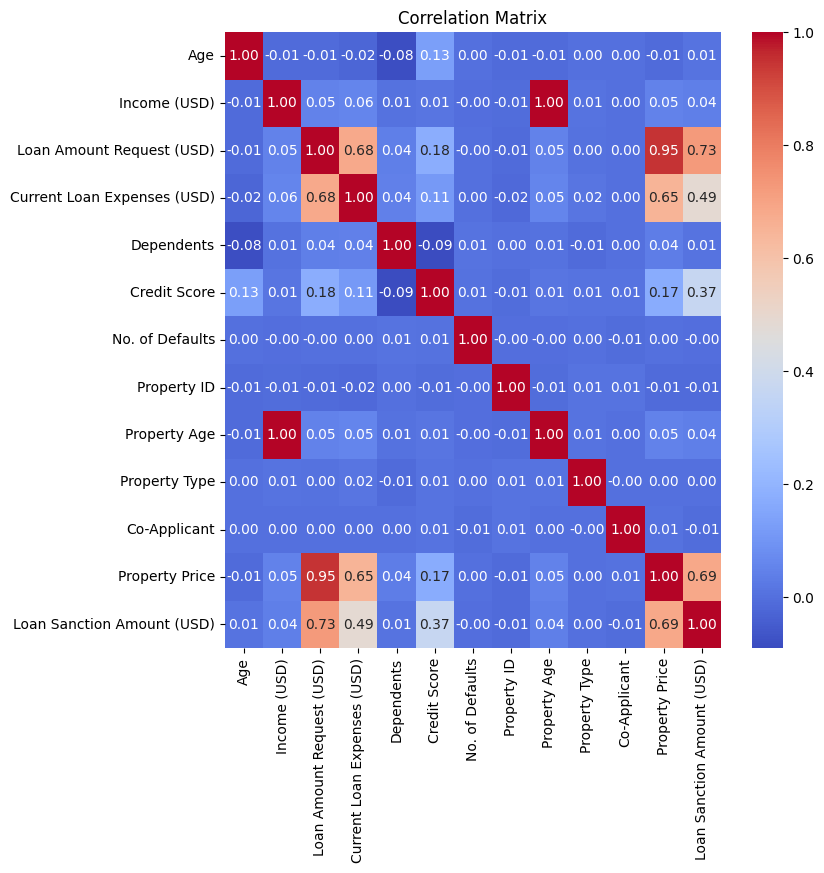

In [44]:
numeric_df = train.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [45]:
target_col = "Loan Sanction Amount (USD)"

X_train = train.drop(columns=[target_col])
y_train = train[target_col]

In [46]:
cols_to_drop = [
    "Name",
    "Customer ID",
    "Property ID"
]

target_col = "Loan Sanction Amount (USD)"

X_train = train.drop(columns=cols_to_drop + [target_col])
y_train = train[target_col]

test = test.drop(columns=cols_to_drop)

KeyError: "['Name', 'Customer ID', 'Property ID'] not found in axis"

In [ ]:
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

In [ ]:
print("Numerical cols:\n", numerical_cols)
print("Categorical cols:\n", categorical_cols)

In [47]:
import numpy as np

# Replace '?' with np.nan in both train and test
X_train.replace("?", np.nan, inplace=True)
test.replace("?", np.nan, inplace=True)

In [48]:
for col in numerical_cols:
    X_train[col] = X_train[col].astype(float)
    test[col]  = test[col].astype(float)

In [49]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median", add_indicator=True)

X_train_num = num_imputer.fit_transform(X_train[numerical_cols])
X_test_num  = num_imputer.transform(test[numerical_cols])

In [50]:
from sklearn.preprocessing import OneHotEncoder

cat_imputer = SimpleImputer(strategy="constant", fill_value="Missing")
X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols])
X_test_cat  = cat_imputer.transform(test[categorical_cols])

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat  = encoder.transform(X_test_cat)

In [51]:
import numpy as np

# Training set
X_train_final = np.hstack([X_train_num, X_train_cat])

# Test set
X_test_final = np.hstack([X_test_num, X_test_cat])

In [52]:
np.isnan(X_train_final).sum(), np.isnan(X_test_final).sum()

(0, 0)

In [84]:
X_train_sub, X_temp, y_train_sub, y_temp = train_test_split(
    X_train_final, y_train, test_size=0.2, random_state=42
)

X_val, X_test_sub, y_val, y_test_sub = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("Train size:", X_train_sub.shape)
print("Validation size:", X_val.shape)
print("Internal test size:", X_test_sub.shape)

Train size: (23728, 35)
Validation size: (2966, 35)
Internal test size: (2966, 35)


In [85]:
model = LinearRegression()
model.fit(X_train_sub, y_train_sub)

y_val_pred = model.predict(X_val)

In [86]:
y_val_pred  = model.predict(X_val)
y_test_pred = model.predict(X_test_sub)

# --- Validation Metrics ---
val_mae  = mean_absolute_error(y_val, y_val_pred)
val_mse  = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2   = r2_score(y_val, y_val_pred)

print("Validation Metrics:")
print(f"MAE : {val_mae:.2f}")
print(f"MSE : {val_mse:.2f}")
print(f"RMSE: {val_rmse:.2f}")
print(f"R²  : {val_r2:.4f}")

# --- Test Metrics (internal test set) ---
test_mae  = mean_absolute_error(y_test_sub, y_test_pred)
test_mse  = mean_squared_error(y_test_sub, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2   = r2_score(y_test_sub, y_test_pred)

print("\nInternal Test Metrics:")
print(f"MAE : {test_mae:.2f}")
print(f"MSE : {test_mse:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²  : {test_r2:.4f}")

Validation Metrics:
MAE : 21103.11
MSE : 1002429332.22
RMSE: 31661.16
R²  : 0.5445

Internal Test Metrics:
MAE : 21418.73
MSE : 988649077.30
RMSE: 31442.79
R²  : 0.5772


In [87]:
model = LinearRegression()

cv_scores = cross_val_score(
    model,
    X_train_final,
    y_train,
    cv=5,
    scoring="r2"
)

print("CV R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

CV R² scores: [0.57221033 0.58168292 0.58240623 0.58196642 0.62257566]
Mean CV R²: 0.5881683123957702


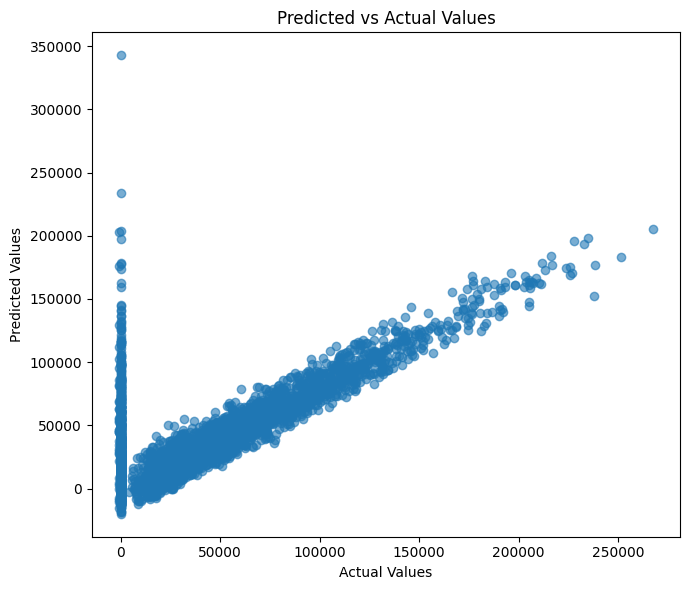

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

plt.scatter(y_val, y_val_pred, alpha=0.6)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")

plt.tight_layout()
plt.savefig("images/linearPreVsAct.png", dpi=150)
plt.show()

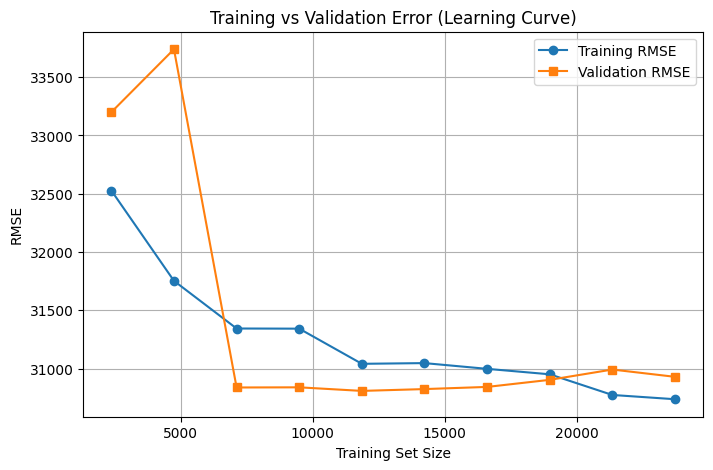

In [114]:
from sklearn.model_selection import learning_curve
model = LinearRegression()

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train_final,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Convert negative MSE to RMSE
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse, marker='o', label="Training RMSE")
plt.plot(train_sizes, val_rmse, marker='s', label="Validation RMSE")

plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Training vs Validation Error (Learning Curve)")
plt.legend()
plt.grid(True)
plt.savefig("images/TrainVsValid.png", dpi=150)
plt.show()

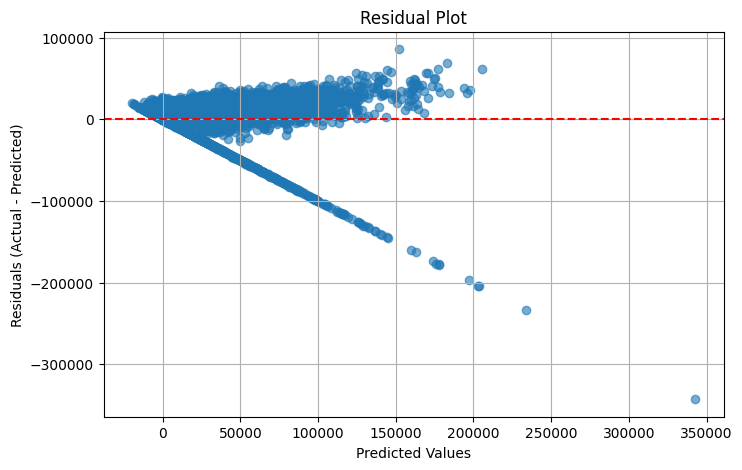

In [115]:
residuals = y_val - y_val_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_val_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # reference line at 0

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.savefig("images/linearRes.png", dpi=150)
plt.show()

In [53]:
model = LinearRegression()

param_grid = {
    "fit_intercept": [True, False]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,              # ⬅️ validation via CV
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train_final, y_train)

,estimator,LinearRegression()
,param_grid,"{'fit_intercept': [True, False]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,fit_intercept,True


In [91]:
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(
    ridge,
    ridge_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# --- Train on training split ---
start_time = time.time()
ridge_grid.fit(X_train_sub, y_train_sub)
end_time = time.time()
ridge_training_time = end_time - start_time

ridge_best_model = ridge_grid.best_estimator_

# --- CV score ---
ridge_best_cv_r2 = ridge_grid.best_score_

# --- Predictions & Metrics ---

# Validation set
y_val_pred_ridge = ridge_best_model.predict(X_val)
val_mae  = mean_absolute_error(y_val, y_val_pred_ridge)
val_mse  = mean_squared_error(y_val, y_val_pred_ridge)
val_rmse = np.sqrt(val_mse)
val_r2   = r2_score(y_val, y_val_pred_ridge)

# Internal Test set
y_test_pred_ridge = ridge_best_model.predict(X_test_sub)
test_mae  = mean_absolute_error(y_test_sub, y_test_pred_ridge)
test_mse  = mean_squared_error(y_test_sub, y_test_pred_ridge)
test_rmse = np.sqrt(test_mse)
test_r2   = r2_score(y_test_sub, y_test_pred_ridge)

# --- Print Results ---
print("Ridge Regression - Hyperparameter Tuning Results\n")
print("Best Parameters:", ridge_grid.best_params_)
print("Best CV R²      :", ridge_best_cv_r2)
print("\nValidation Metrics:")
print(f"MAE : {val_mae:.2f}")
print(f"MSE : {val_mse:.2f}")
print(f"RMSE: {val_rmse:.2f}")
print(f"R²  : {val_r2:.4f}")
print("\nInternal Test Metrics:")
print(f"MAE : {test_mae:.2f}")
print(f"MSE : {test_mse:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²  : {test_r2:.4f}")
print("\nTraining Time (s):", ridge_training_time)

Ridge Regression - Hyperparameter Tuning Results

Best Parameters: {'alpha': 100}
Best CV R²      : 0.58894429677118

Validation Metrics:
MAE : 21086.35
MSE : 1001589383.17
RMSE: 31647.90
R²  : 0.5449

Internal Test Metrics:
MAE : 21424.25
MSE : 988873190.77
RMSE: 31446.35
R²  : 0.5771

Training Time (s): 4.690750598907471


In [92]:
from sklearn.linear_model import Lasso

# --- Hyperparameter Grid ---
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso = Lasso(random_state=42)
lasso_grid = GridSearchCV(
    lasso,
    lasso_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# --- Train ---
start_time = time.time()
lasso_grid.fit(X_train_sub, y_train_sub)
end_time = time.time()
lasso_training_time = end_time - start_time

lasso_best_model = lasso_grid.best_estimator_

# --- CV score ---
lasso_best_cv_r2 = lasso_grid.best_score_

# --- Predictions & Metrics ---
# Validation set
y_val_pred_lasso = lasso_best_model.predict(X_val)
val_mae  = mean_absolute_error(y_val, y_val_pred_lasso)
val_mse  = mean_squared_error(y_val, y_val_pred_lasso)
val_rmse = np.sqrt(val_mse)
val_r2   = r2_score(y_val, y_val_pred_lasso)

# Internal Test set
y_test_pred_lasso = lasso_best_model.predict(X_test_sub)
test_mae  = mean_absolute_error(y_test_sub, y_test_pred_lasso)
test_mse  = mean_squared_error(y_test_sub, y_test_pred_lasso)
test_rmse = np.sqrt(test_mse)
test_r2   = r2_score(y_test_sub, y_test_pred_lasso)

# --- Print Results ---
print("Lasso Regression - Hyperparameter Tuning Results\n")
print("Best Parameters:", lasso_grid.best_params_)
print("Best CV R²      :", lasso_best_cv_r2)
print("\nValidation Metrics:")
print(f"MAE : {val_mae:.2f}")
print(f"MSE : {val_mse:.2f}")
print(f"RMSE: {val_rmse:.2f}")
print(f"R²  : {val_r2:.4f}")
print("\nInternal Test Metrics:")
print(f"MAE : {test_mae:.2f}")
print(f"MSE : {test_mse:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²  : {test_r2:.4f}")
print("\nTraining Time (s):", lasso_training_time)

Lasso Regression - Hyperparameter Tuning Results

Best Parameters: {'alpha': 10}
Best CV R²      : 0.5890878592576936

Validation Metrics:
MAE : 21089.94
MSE : 1001445007.21
RMSE: 31645.62
R²  : 0.5449

Internal Test Metrics:
MAE : 21426.30
MSE : 988395979.97
RMSE: 31438.77
R²  : 0.5773

Training Time (s): 23.578380823135376


In [93]:
from sklearn.linear_model import ElasticNet

# --- Hyperparameter Grid ---
elastic_params = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.2, 0.5, 0.8]
}

elastic = ElasticNet(random_state=42)
elastic_grid = GridSearchCV(
    elastic,
    elastic_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# --- Train ---
start_time = time.time()
elastic_grid.fit(X_train_sub, y_train_sub)
end_time = time.time()
elastic_training_time = end_time - start_time

elastic_best_model = elastic_grid.best_estimator_

# --- CV score ---
elastic_best_cv_r2 = elastic_grid.best_score_

# --- Predictions & Metrics ---
# Validation set
y_val_pred_elastic = elastic_best_model.predict(X_val)
val_mae  = mean_absolute_error(y_val, y_val_pred_elastic)
val_mse  = mean_squared_error(y_val, y_val_pred_elastic)
val_rmse = np.sqrt(val_mse)
val_r2   = r2_score(y_val, y_val_pred_elastic)

# Internal Test set
y_test_pred_elastic = elastic_best_model.predict(X_test_sub)
test_mae  = mean_absolute_error(y_test_sub, y_test_pred_elastic)
test_mse  = mean_squared_error(y_test_sub, y_test_pred_elastic)
test_rmse = np.sqrt(test_mse)
test_r2   = r2_score(y_test_sub, y_test_pred_elastic)

# --- Print Results ---
print("ElasticNet Regression - Hyperparameter Tuning Results\n")
print("Best Parameters:", elastic_grid.best_params_)
print("Best CV R²      :", elastic_best_cv_r2)
print("\nValidation Metrics:")
print(f"MAE : {val_mae:.2f}")
print(f"MSE : {val_mse:.2f}")
print(f"RMSE: {val_rmse:.2f}")
print(f"R²  : {val_r2:.4f}")
print("\nInternal Test Metrics:")
print(f"MAE : {test_mae:.2f}")
print(f"MSE : {test_mse:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²  : {test_r2:.4f}")
print("\nTraining Time (s):", elastic_training_time)

ElasticNet Regression - Hyperparameter Tuning Results

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.2}
Best CV R²      : 0.5889521721553305

Validation Metrics:
MAE : 21080.35
MSE : 1001466603.48
RMSE: 31645.96
R²  : 0.5449

Internal Test Metrics:
MAE : 21427.69
MSE : 989141953.56
RMSE: 31450.63
R²  : 0.5770

Training Time (s): 13.815705060958862


In [120]:
import matplotlib.pyplot as plt

def plot_pred_vs_actual(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_val, y_pred, alpha=0.6)
   # plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} - Predicted vs Actual")
    plt.grid(True)
    #plt.show()
    return plt

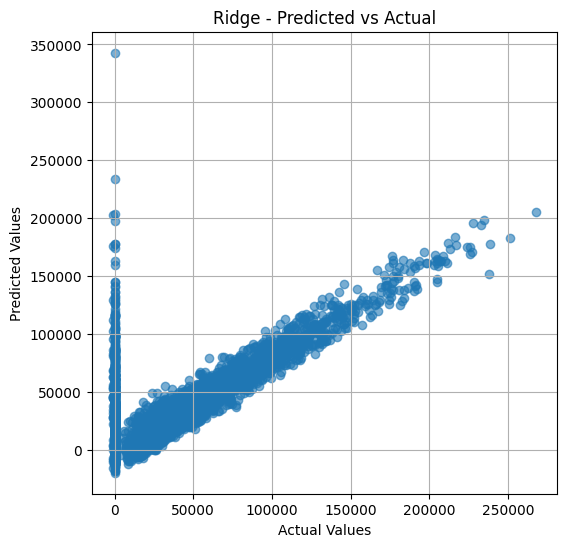

In [121]:
plot_pred_vs_actual(ridge_best_model, X_val, y_val, "Ridge")
plt.savefig("images/RidgePreVsAct.png", dpi=150)

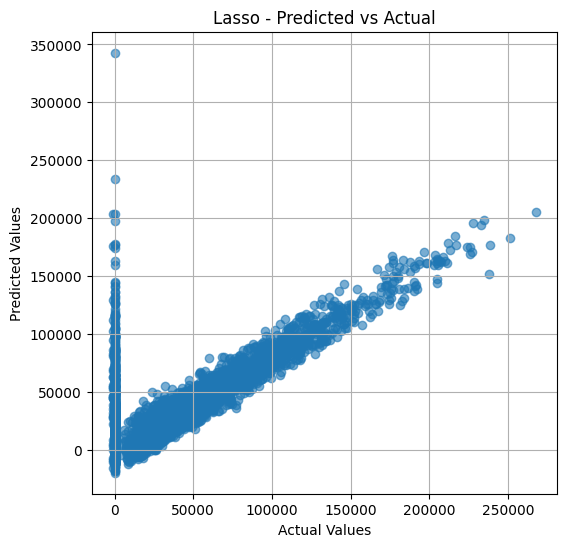

In [122]:
plot_pred_vs_actual(lasso_best_model, X_val, y_val, "Lasso")
plt.savefig("images/LassoPreVsAct.png", dpi=150)

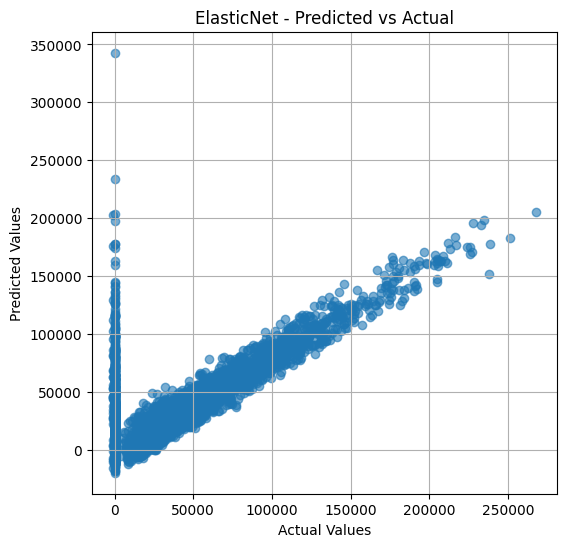

In [123]:
plot_pred_vs_actual(elastic_best_model, X_val, y_val, "ElasticNet")
plt.savefig("images/ElasticPreVsAct.png", dpi=150)

In [155]:
def plot_learning_curve(model, X_train, y_train, model_name, scoring='neg_mean_absolute_error'):
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np

    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )
    
    # Compute mean (ignore std)
    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean   = -np.mean(val_scores, axis=1)
    
    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Error')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='orange', label='Validation Error')
    
    plt.xlabel("Training Set Size")
    plt.ylabel("MAE")
    plt.title(f"{model_name} - Learning Curve (MAE)")
    plt.legend(loc='best')
    plt.grid(True)
    #plt.show()
    return plt

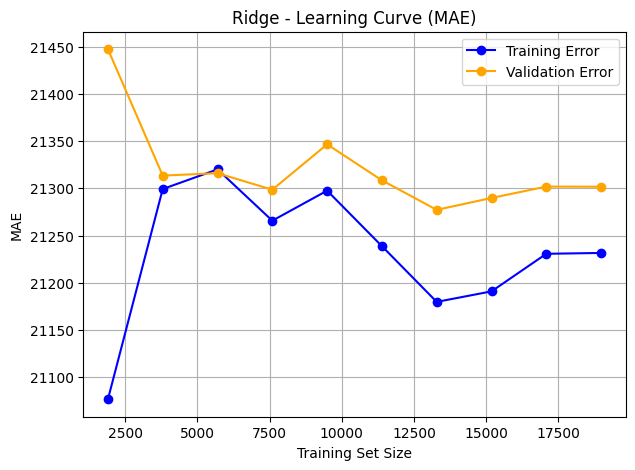

In [156]:
plot_learning_curve(ridge_best_model, X_train_sub, y_train_sub, "Ridge")
plt.savefig("images/RidgeTrainVsValid.png", dpi=150)

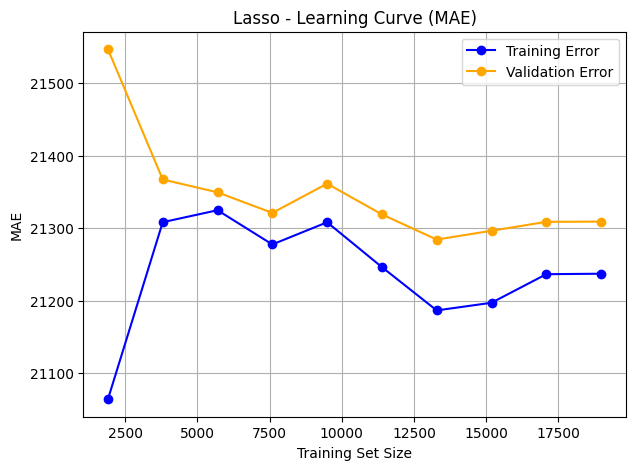

In [157]:
plot_learning_curve(lasso_best_model, X_train_sub, y_train_sub, "Lasso")
plt.savefig("images/LassoTrainVsValid.png", dpi=150)

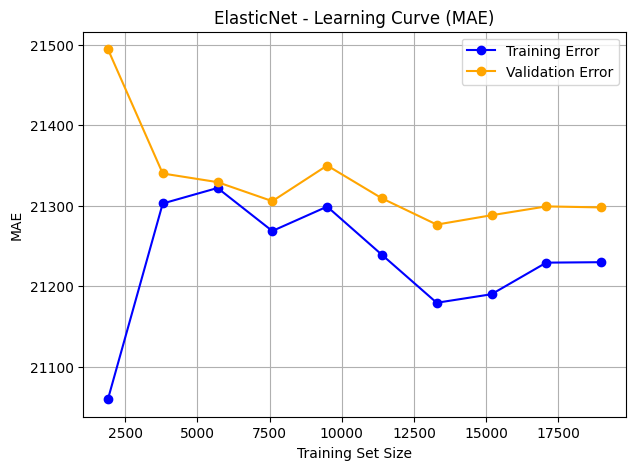

In [158]:
plot_learning_curve(elastic_best_model, X_train_sub, y_train_sub, "ElasticNet")
plt.savefig("images/ElasticTrainVsValid.png", dpi=150)

In [159]:
def plot_residuals(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    residuals = y_val - y_pred
    
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='--', lw=2)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"{model_name} - Residual Plot (Validation)")
    plt.grid(True)
   # plt.show()
    return plt

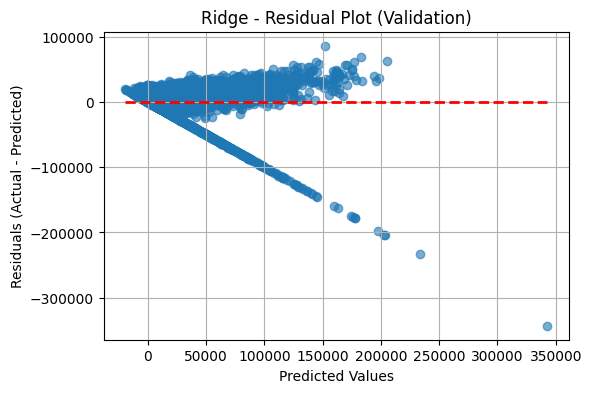

In [160]:
plot_residuals(ridge_best_model, X_val, y_val, "Ridge")
plt.savefig("images/RidgeRes.png", dpi=150)

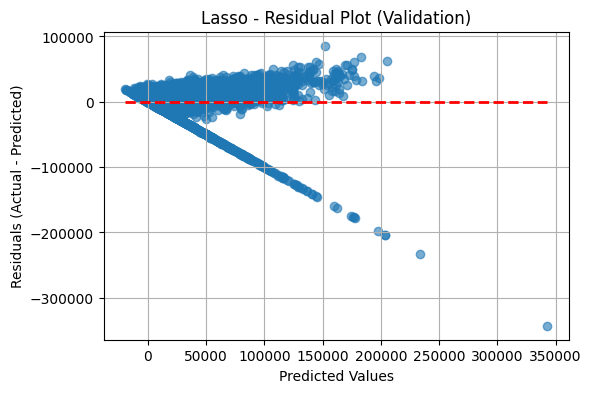

In [161]:
plot_residuals(lasso_best_model, X_val, y_val, "Lasso")
plt.savefig("images/LassoRes.png", dpi=150)

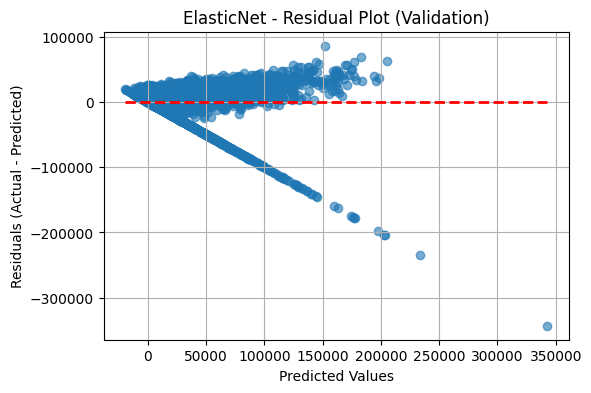

In [162]:
plot_residuals(elastic_best_model, X_val, y_val, "ElasticNet")
plt.savefig("images/ElasticRes.png", dpi=150)

In [163]:
X_train_final_df = pd.DataFrame(X_train_final)

# Get all column names
feature_names = X_train_final_df.columns.tolist()

print(feature_names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [107]:
print("Number of features:", len(feature_names))
print("Length of model.coef_:", len(ridge_best_model.coef_))

Number of features: 35
Length of model.coef_: 35


In [149]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coefficients(models, model_names, feature_names):
    n_features = len(feature_names)
    x = np.arange(n_features)  # positions for features
    width = 0.25  # width of each bar

    plt.figure(figsize=(max(15, n_features*0.4),8))

    for i, model in enumerate(models):
        coefs = model.coef_
        plt.bar(x + i*width, coefs, width=width, label=model_names[i])

    plt.xticks(x + width, feature_names, rotation=90)
    plt.ylabel("Coefficient Value")
    plt.title("Coefficient Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("images/CoefficientComparision.png", dpi=150)
    plt.show()

In [150]:
# encoder is your OneHotEncoder from above
cat_features = encoder.get_feature_names_out(categorical_cols)
print(cat_features)

['Gender_F' 'Gender_M' 'Gender_Missing' 'Income Stability_High'
 'Income Stability_Low' 'Income Stability_Missing'
 'Type of Employment_Accountants' 'Type of Employment_Cleaning staff'
 'Type of Employment_Cooking staff' 'Type of Employment_Core staff'
 'Type of Employment_Drivers' 'Type of Employment_HR staff'
 'Type of Employment_High skill tech staff' 'Type of Employment_IT staff'
 'Type of Employment_Laborers' 'Type of Employment_Low-skill Laborers'
 'Type of Employment_Managers' 'Type of Employment_Medicine staff'
 'Type of Employment_Missing' 'Type of Employment_Private service staff'
 'Type of Employment_Realty agents' 'Type of Employment_Sales staff'
 'Type of Employment_Secretaries' 'Type of Employment_Security staff'
 'Type of Employment_Waiters/barmen staff' 'Has Active Credit Card_Active'
 'Has Active Credit Card_Inactive' 'Has Active Credit Card_Missing'
 'Has Active Credit Card_Unpossessed']


In [177]:
# Original numerical columns
numerical_cols = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Credit Score']

# Number of indicators added
n_indicators = X_train_num.shape[1] - len(numerical_cols)

# Create numerical feature names including indicator columns
num_features = numerical_cols + [f"{col}_missing_indicator" for col in range(n_indicators)]

In [178]:
feature_names = num_features + list(cat_features)

print("Number of features:", len(feature_names))
print(feature_names)  # check first 10 names

Number of features: 35
['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Credit Score', '0_missing_indicator', '1_missing_indicator', 'Gender_F', 'Gender_M', 'Gender_Missing', 'Income Stability_High', 'Income Stability_Low', 'Income Stability_Missing', 'Type of Employment_Accountants', 'Type of Employment_Cleaning staff', 'Type of Employment_Cooking staff', 'Type of Employment_Core staff', 'Type of Employment_Drivers', 'Type of Employment_HR staff', 'Type of Employment_High skill tech staff', 'Type of Employment_IT staff', 'Type of Employment_Laborers', 'Type of Employment_Low-skill Laborers', 'Type of Employment_Managers', 'Type of Employment_Medicine staff', 'Type of Employment_Missing', 'Type of Employment_Private service staff', 'Type of Employment_Realty agents', 'Type of Employment_Sales staff', 'Type of Employment_Secretaries', 'Type of Employment_Security staff', 'Type of Employment_Waiters/barmen staff', 'Has Active Credit Card_Active', 'Has Active Credit Card_Inactive', '

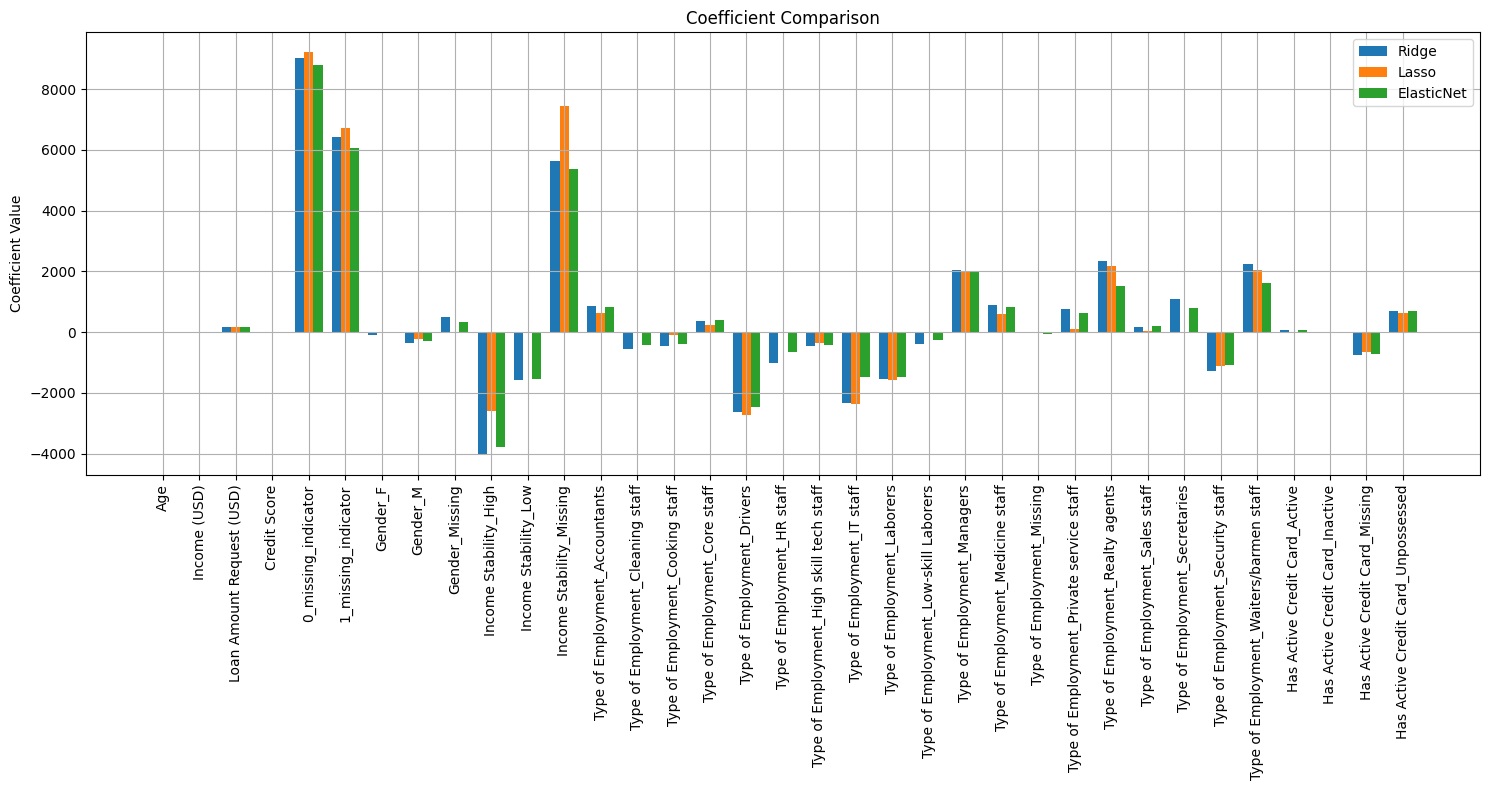

In [179]:
models = [ridge_best_model, lasso_best_model, elastic_best_model]
model_names = ["Ridge", "Lasso", "ElasticNet"]

plot_coefficients(models, model_names, feature_names)

In [ ]:
'Customer ID', 'Name', 'Gender', 'Income Stability', 'Profession',
       'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2',
       'Has Active Credit Card', 'Property Location','Age', 'Income (USD)', 'Loan Amount Request (USD)',
       'Current Loan Expenses (USD)', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Property ID', 'Property Age', 'Property Type',
       'Co-Applicant', 'Property Price'

In [173]:
num_features = numerical_cols + [f"{col}_missing_indicator" for col in range(X_train_num.shape[1] - len(numerical_cols))]
cat_features = encoder.get_feature_names_out(categorical_cols)
feature_names = num_features + list(cat_features)

coefs = ridge_best_model.coef_

for name, coef in zip(feature_names, coefs):
    print(f"{name}: {coef:.4f}")

Age: 0.0052
Income (USD): 0.5777
Loan Amount Request (USD): 165.2071
Credit Score: -0.0113
0_missing_indicator: 9009.1165
1_missing_indicator: 6435.4392
Gender_F: -113.4693
Gender_M: -372.0382
Gender_Missing: 485.5075
Income Stability_High: -4037.9232
Income Stability_Low: -1594.2948
Income Stability_Missing: 5632.2180
Type of Employment_Accountants: 850.5376
Type of Employment_Cleaning staff: -558.2651
Type of Employment_Cooking staff: -463.0146
Type of Employment_Core staff: 369.0949
Type of Employment_Drivers: -2642.1229
Type of Employment_HR staff: -1033.2009
Type of Employment_High skill tech staff: -473.4367
Type of Employment_IT staff: -2336.4485
Type of Employment_Laborers: -1536.4118
Type of Employment_Low-skill Laborers: -394.7243
Type of Employment_Managers: 2057.1856
Type of Employment_Medicine staff: 881.2698
Type of Employment_Missing: -20.9187
Type of Employment_Private service staff: 772.3585
Type of Employment_Realty agents: 2326.2302
Type of Employment_Sales staff: 17

In [166]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_final, y_train)   # IMPORTANT

print(model.coef_.shape)            # sanity check

(35,)


In [167]:
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Linear": model.coef_,
    "Ridge": ridge_best_model.coef_,
    "Lasso": lasso_best_model.coef_,
    "Elastic Net": elastic_best_model.coef_
})

In [169]:
coef_df["Abs_Elastic"] = np.abs(coef_df["Elastic Net"])
coef_df_sorted = coef_df.sort_values("Abs_Elastic", ascending=False)

# View top coefficients
coef_df_sorted.head(10)
coef_df_sorted[["Feature", "Linear", "Ridge", "Lasso", "Elastic Net"]].head(3)

,Feature,Linear,Ridge,Lasso,Elastic Net
4,4,9398.737559,9009.116494,9203.684514,8791.554910
5,5,7220.175813,6435.439198,6731.754406,6057.561994
11,11,5937.500584,5632.217952,7436.769724,5362.597540
9,9,-4221.422961,-4037.923154,-2611.374503,-3799.176679
16,16,-2935.119804,-2642.122925,-2721.943262,-2453.384629
22,22,1773.864847,2057.185604,1966.416757,1996.876833
30,30,4361.833629,2226.802189,2040.321141,1605.101511
10,10,-1716.077622,-1594.294797,-0.000000,-1563.170862
26,26,2617.981184,2326.230249,2181.544028,1498.832853
19,19,-5976.765570,-2336.448547,-2384.093591,-1481.444936


In [170]:
num_imputer.indicator_.features_

array([0, 2], dtype=int64)